# Data Gathering

In [1]:
from pathlib import Path
from datetime import datetime
import sys


# Define the base directory
base_dir = Path.cwd().resolve().parents[1]

# Define subdirectories
data_dir = base_dir / "data"
model_dir = base_dir / "models"
notebooks_dir = base_dir / "notebooks"

# Append base_dir to sys.path
sys.path.append(str(base_dir))

from axyom_utilities.data_extraction import extract_data

X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, log_transform=True)


In [ ]:
import pandas as pd
import glob
from pathlib import Path

def get_meta_data(meta_data_dir, oof_joker="*_oof.csv", test_joker="*_test.csv"):
    meta_data_dir = Path(meta_data_dir)
    # Define file patterns for OOF and test predictions
    oof_catch = str(meta_data_dir / oof_joker)
    test_catch = str(meta_data_dir / test_joker)
    
    oof_files = sorted(glob.glob(oof_catch))  # Sorted for consistency
    test_files = sorted(glob.glob(test_catch))  # Sorted for consistency
    
    #print(test_files)

    # Ensure the number of files matches
    assert len(oof_files) == len(test_files), "Mismatch in the number of OOF and test files."

    # Function to load and rename files with prefixes
    def load_and_prefix(files, prefix):
        dfs = []
        for file in files:
            # Extract only the base name without directory and suffix
            model_name = Path(file).stem.replace("_oof", "").replace("_test", "")
            df = pd.read_csv(file)
                        
            if len(df) == 1600000:
                #print("not good")
                # TODO fix in the source, not here
                #print(model_name)
                df = df.iloc[-len(df)//2:].reset_index(drop=True)
                
                
            #print(df.head(2))  
                
            #print(df.head(4))
            df.columns = [f"{prefix}{model_name}_F{i+1}" for i in range(df.shape[1])]
            
            #print(df.columns)
            
            dfs.append(df)
        return pd.concat(dfs, axis=1)

    # Load OOF and test predictions with identical features
    X_meta_train = load_and_prefix(oof_files, prefix="")
    X_meta_test = load_and_prefix(test_files, prefix="")

    # Ensure the columns are identical between train and test
    X_meta_test.columns = X_meta_train.columns

    # Check the shapes
    print(f"Meta-train shape: {X_meta_train.shape}")
    print(f"Meta-test shape: {X_meta_test.shape}")
    
    return X_meta_train, X_meta_test

# Example usage
#X_meta_train, X_meta_test = get_meta_data("notebooks/Ensemble Catboost XGBoost LGBM")

# mikail
X_meta_train_mikail, X_meta_test_mikail = get_meta_data(notebooks_dir/"Ensemble Catboost XGBoost LGBM")

#print(X_meta_train_mikail.head())

def file_exists(filepath):
    file_path = Path(filepath)
    if not file_path.is_file():
        raise FileNotFoundError(f"The file '{filepath}' does not exist.")

def get_oof_test(filename, column_name):        
    df = pd.read_csv(filename)
    
    if df.shape[1] > 1:
        # If multiple columns, get last one
        df = pd.DataFrame(df.iloc[:, 1], columns=[column_name])
        
    # If single column, assign the provided column name
    df.columns = [column_name]
    return df

# Axyom
lgbm2_train = get_oof_test(notebooks_dir/"LGBM_v2\\1.0313+-0.0008\\oof_preds.csv", "LGBM_v2_axyom")
lgbm2_test = get_oof_test(notebooks_dir/"LGBM_v2\\1.0313+-0.0008\\test_preds.csv", "LGBM_v2_axyom")

autogluon_v2_train = get_oof_test(notebooks_dir/"Autogluon_v2\\AutogluonModels\\ag-20241225_165244\\oof_preds.csv", "autogluon_v2_axyom")
autogluon_v2_test = get_oof_test(notebooks_dir/"Autogluon_v2\\AutogluonModels\\ag-20241225_165244\\test_preds.csv", "autogluon_v2_axyom")

catboost_v2_train = get_oof_test(notebooks_dir/"Catboost_nonlog_feature\\1.0309+-0.0008\\oof_preds.csv", "catboost_v2_axyom")
catboost_v2_test = get_oof_test(notebooks_dir/"Catboost_nonlog_feature\\1.0309+-0.0008\\test_preds.csv", "catboost_v2_axyom")

xgboost_v2_train = get_oof_test(notebooks_dir/"XGBoost v2/1.0312+-0.0007\\oof_preds.csv", "xgboost_v2_axyom")
xgboost_v2_test = get_oof_test(notebooks_dir/"XGBoost v2/1.0312+-0.0007\\test_preds.csv", "xgboost_v2_axyom")

# arno
catboost_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_catboost_oof_preds.csv", "catboost_kaggle")
catboost_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_catboost_test_preds.csv", "catboost_kaggle")

lgbm_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_lgbm_oof_preds.csv", "lgbm_kaggle")
lgbm_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_lgbm_test_preds.csv", "lgbm_kaggle")

xgb_kaggle_train = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_xgb_oof_preds.csv", "xgb_kaggle")
xgb_kaggle_test = get_oof_test(notebooks_dir/"Kaggle computed ensemble\\cleaned_xgb_test_preds.csv", "xgb_kaggle")

# CONCATENATION
X_meta_train = pd.concat([
    X_meta_train_mikail, 
    lgbm2_train, 
    autogluon_v2_train, 
    catboost_v2_train, 
    xgboost_v2_train,
    catboost_kaggle_train, 
    lgbm_kaggle_train, 
    xgb_kaggle_train
], axis=1)
X_meta_test =  pd.concat([
    X_meta_test_mikail, 
    lgbm2_test,
    autogluon_v2_test, 
    catboost_v2_test,
    xgboost_v2_test, 
    catboost_kaggle_test, 
    lgbm_kaggle_test, 
    xgb_kaggle_test
], axis=1)


Meta-train shape: (1200000, 27)
Meta-test shape: (800000, 27)
    CAT2_F1   CAT3_F1   CAT4_F1   CAT5_F1   CAT6_F1   CAT8_F1   CAT9_F1  \
0  6.879656  6.878609  6.888915  6.880599  6.844798  6.880209  6.857543   
1  6.603727  6.604122  6.612402  6.590276  6.711615  6.600636  6.605473   
2  6.731330  6.727038  6.734683  6.747237  6.770649  6.727395  6.735930   
3  6.804395  6.809789  6.767255  6.807785  6.702834  6.790446  6.796255   
4  6.820363  6.830094  6.827049  6.822431  6.766598  6.821919  6.819712   

     CAT_F1   HGB2_F1   HGB3_F1  ...  LGBM8_F1  LGBM9_F1   LGBM_F1   XGB2_F1  \
0  6.879306  6.881209  6.880418  ...  6.897672  6.890580  6.856897  6.870620   
1  6.617835  6.598084  6.591714  ...  6.590937  6.592692  6.592067  6.607316   
2  6.713660  6.726840  6.729418  ...  6.728329  6.721480  6.737296  6.735967   
3  6.801755  6.807567  6.793407  ...  6.865108  6.831611  6.792099  6.835166   
4  6.824475  6.807433  6.807429  ...  6.822183  6.817229  6.803202  6.809719   

    XG

In [21]:
X_meta_train

,CAT2_F1,CAT3_F1,CAT4_F1,CAT5_F1,CAT6_F1,CAT8_F1,CAT9_F1,CAT_F1,HGB2_F1,HGB3_F1,...,XGB6_F1,XGB8_F1,XGB_F1,LGBM_v2_axyom,autogluon_v2_axyom,catboost_v2_axyom,xgboost_v2_axyom,catboost_kaggle,lgbm_kaggle,xgb_kaggle
0,6.879656,6.878609,6.888915,6.880599,6.844798,6.880209,6.857543,6.879306,6.881209,6.880418,...,6.878317,6.869698,6.879441,6.882895,6.865344,6.893105,6.867620,6.881234,6.842678,6.839812
1,6.603727,6.604122,6.612402,6.590276,6.711615,6.600636,6.605473,6.617835,6.598084,6.591714,...,6.592738,6.596825,6.595139,6.576740,6.599874,6.637723,6.597183,6.594889,6.592382,6.594367
2,6.731330,6.727038,6.734683,6.747237,6.770649,6.727395,6.735930,6.713660,6.726840,6.729418,...,6.738655,6.739345,6.754562,6.730502,6.735925,6.768459,6.721693,6.704542,6.714395,6.723536
3,6.804395,6.809789,6.767255,6.807785,6.702834,6.790446,6.796255,6.801755,6.807567,6.793407,...,6.836875,6.838369,6.800961,6.821496,6.794538,6.830385,6.843273,6.844987,6.818417,6.840056
4,6.820363,6.830094,6.827049,6.822431,6.766598,6.821919,6.819712,6.824475,6.807433,6.807429,...,6.809700,6.814489,6.823993,6.813567,6.800051,6.642096,6.812170,6.810781,6.817370,6.813779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,6.915602,6.925285,6.907171,6.918143,6.887570,6.914079,6.924232,6.944999,6.910259,6.908276,...,6.895965,6.895347,6.937392,6.915423,6.886085,6.879275,6.903190,6.910383,6.891430,6.894538
1199996,6.769553,6.772158,6.776487,6.777134,6.720663,6.775982,6.778171,6.742666,6.769451,6.770576,...,6.775882,6.769505,6.735462,6.771563,6.771649,6.783833,6.777412,6.776988,6.776798,6.783721
1199997,5.232226,5.242050,5.312352,5.254823,5.607344,5.234463,5.230846,5.174806,5.244530,5.228245,...,5.282940,5.249376,5.301820,5.238006,5.282425,5.111880,5.252008,5.224594,5.303931,5.331536
1199998,6.830614,6.817938,6.812025,6.809251,6.767027,6.824788,6.830950,6.850570,6.820464,6.816830,...,6.820324,6.807199,6.817419,6.784793,6.791085,6.872786,6.796462,6.828211,6.807533,6.812346


# Meta Training

[I 2024-12-27 23:56:04,177] A new study created in memory with name: no-name-7b259e9c-9391-4826-88d7-d0f3695f07ac
[I 2024-12-27 23:56:04,376] Trial 0 finished with value: 1.0309959705767697 and parameters: {'weight_0': 0.3262964355547947, 'weight_1': 0.4259467912548768, 'weight_2': 0.2808361779985227, 'weight_3': 0.43847556634827256, 'weight_4': 0.5425978611524185, 'weight_5': 0.5381287521734771, 'weight_6': 0.9134444070836266, 'weight_7': 0.11877048068395213, 'weight_8': 0.050354803190158615, 'weight_9': 0.005630069434837459, 'weight_10': 0.06707440091797112, 'weight_11': 0.5988261091469476, 'weight_12': 0.5652804711069039, 'weight_13': 0.30776501075913143, 'weight_14': 0.5616409942634241, 'weight_15': 0.5889534907603763, 'weight_16': 0.47413270183993006, 'weight_17': 0.7273744861127713, 'weight_18': 0.8386610006726508, 'weight_19': 0.06914000152139166, 'weight_20': 0.8073150150615858, 'weight_21': 0.6915834803554126, 'weight_22': 0.6481416593293355, 'weight_23': 0.22903881361805722, 

Optimized Weights: [0.00689207 0.0419722  0.00535223 0.03084369 0.00016691 0.00740327
 0.01192771 0.02218436 0.00785083 0.01279433 0.02946968 0.04281664
 0.00828424 0.01144582 0.01756753 0.08771249 0.02506245 0.02608089
 0.04609681 0.00593137 0.04294141 0.01584767 0.01113426 0.07297507
 0.00174749 0.03733414 0.01089685 0.05651356 0.0789203  0.10590233
 0.00888071 0.00419914 0.09593299 0.00891856]
Best RMSE: 1.0303638526431365


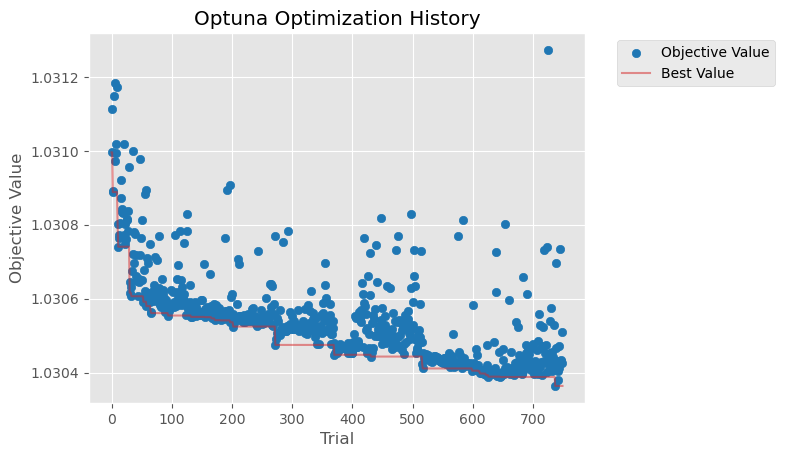

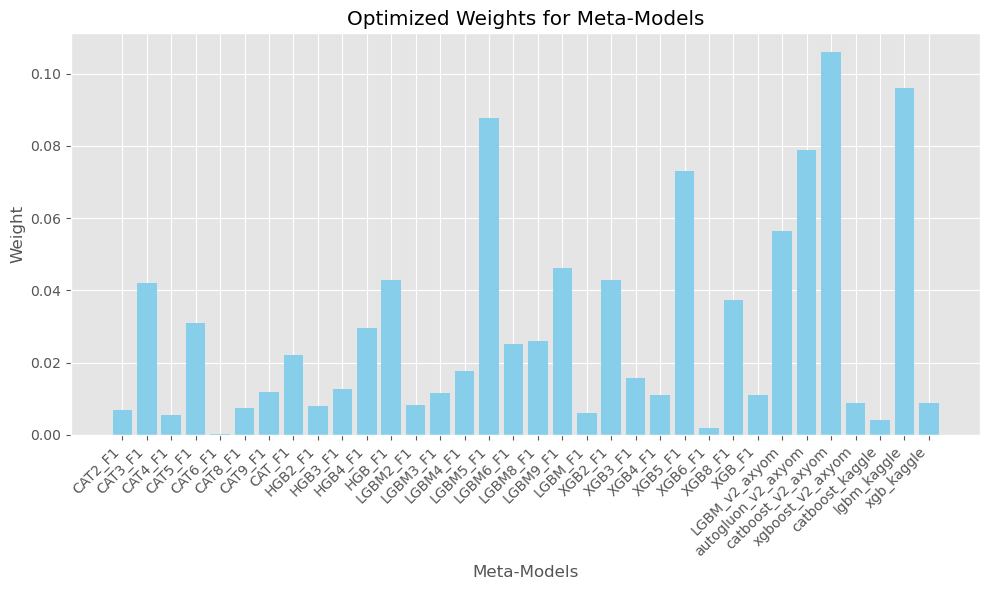

In [22]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error
from optuna.visualization.matplotlib import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
import matplotlib.pyplot as plt

def optimize_ensemble_weights(X_meta_train, X_meta_test, y_train, n_trials=100):
    """
    Optimize ensemble weights for a given set of meta-features using Optuna.
    
    Parameters:
        X_meta_train (pd.DataFrame): OOF predictions (meta-features) for training.
        X_meta_test (pd.DataFrame): Predictions for the test set (meta-features).
        y_train (pd.Series): True target values for training.
        n_trials (int): Number of trials for Optuna optimization.
    
    Returns:
        dict: Optimized weights for each meta-model.
        np.ndarray: Final predictions on the test set.
    """
    # Define the objective function
    def objective(trial):
        num_models = X_meta_train.shape[1]
        weights = [trial.suggest_float(f"weight_{i}", 0, 1) for i in range(num_models)]
        weights = np.array(weights) / sum(weights)  # Normalize weights to sum to 1
        ensemble_preds = (X_meta_train.values * weights).sum(axis=1)
        rmse = np.sqrt(mean_squared_error(y_train, ensemble_preds))
        return rmse

    # Initialize and optimize the study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    # df = study.trials_dataframe()
    # print(df)  

    # Retrieve the best weights
    best_weights = study.best_params
    normalized_weights = np.array([best_weights[f"weight_{i}"] for i in range(len(best_weights))])
    normalized_weights /= normalized_weights.sum()

    # Generate predictions for the test set
    test_preds = (X_meta_test.values * normalized_weights).sum(axis=1)

    # Print optimization results
    print("Optimized Weights:", normalized_weights)
    print("Best RMSE:", study.best_value)

    # Plot optimization history
    plot = plot_optimization_history(study)
    plt.title("Optuna Optimization History")
    plt.show()
    
    weight_mapping = dict(zip(X_meta_train.columns, normalized_weights))
    
    # Plot bar chart of weights
    plt.figure(figsize=(10, 6))
    plt.bar(weight_mapping.keys(), weight_mapping.values(), color="skyblue")
    plt.title("Optimized Weights for Meta-Models")
    plt.xlabel("Meta-Models")
    plt.ylabel("Weight")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return best_weights, test_preds, study.best_value

# Assuming meta_features (training meta-features), meta_predictions (test meta-features),
# and y_train (true target values) are already defined.
optimized_weights, test_preds, weight_ensembling_score = optimize_ensemble_weights(
    X_meta_train=X_meta_train,
    X_meta_test=X_meta_test,
    y_train=y_train,
    n_trials=750
)

In [24]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from axyom_utilities.training import train_model_cv
from axyom_utilities.wrappers import RidgeRegressorWrapper, LGBMRegressorWrapper

# Neural Network class
class NeuralNetwork:
    def __init__(self, input_dim, learning_rate=0.001):
        self.model = Sequential([
            Dense(128, activation='relu', input_dim=input_dim),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    def fit(self, X_train, y_train, epochs=50, batch_size=32, verbose=0):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        return self.model.predict(X).flatten().ravel()

# Initialize models
meta_models = {
    #"Ridge": RidgeRegressorWrapper(alpha=1.0, random_state=42),
    "LightGBM": LGBMRegressorWrapper(random_state=42, verbose=-1)
    #"NeuralNetwork": NeuralNetwork(input_dim=X_meta_train.shape[1])
}



# Train and evaluate models
results = {}
for name, model in meta_models.items():
    r = train_model_cv(model, X_meta_train, y_train, X_meta_test, cv_splits=10)
    
    oof_preds = r['oof_preds']
    test_preds = r['test_preds']
    score = np.mean(r['cv_scores'])
    
    results[name] = {"oof_preds": oof_preds, "test_preds": test_preds, "score":score}
    print(f"{name} OOF RMSE: {score:.6f}")

# Compare stacking methods
# for method, result in results.items():
#     print(f"{method}: OOF RMSE = {result['oof_rmse']:.4f}")
# Find the best model
# best_model = max(results.items(), key=lambda x: x[1]["score"])
# best_name, best_data = best_model

# # Extract relevant details
# best_oof_preds = best_data["oof_preds"]
# best_test_preds = best_data["test_preds"]

# print(f"Best Model Name: {best_name}")
# print(f"OOF Predictions: {best_oof_preds}")
# print(f"Test Predictions: {best_test_preds}")


Training fold 1...
Fold 1 RMSE: 1.0314
Training fold 2...
Fold 2 RMSE: 1.0265
Training fold 3...
Fold 3 RMSE: 1.0262
Training fold 4...
Fold 4 RMSE: 1.0304
Training fold 5...
Fold 5 RMSE: 1.0298
Training fold 6...
Fold 6 RMSE: 1.0247
Training fold 7...
Fold 7 RMSE: 1.0303
Training fold 8...
Fold 8 RMSE: 1.0289
Training fold 9...
Fold 9 RMSE: 1.0314
Training fold 10...
Fold 10 RMSE: 1.0256
Mean CV RMSE: 1.0285 ± 0.0024
LightGBM OOF RMSE: 1.028527


[I 2024-12-28 00:46:31,550] Using an existing study with name 'lgbm' instead of creating a new one.


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 1.02927
Fold 1 RMSE: 1.0293
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 1.0287
Fold 2 RMSE: 1.0287
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 1.02749
Fold 3 RMSE: 1.0275
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 1.02983
Fold 4 RMSE: 1.0298
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 1.02898


[I 2024-12-28 00:47:12,757] Trial 3 finished with value: 1.0288547036138127 and parameters: {'learning_rate': 0.05433350003437882, 'max_depth': 14, 'num_leaves': 210, 'min_child_samples': 74, 'min_child_weight': 29.571435175175054, 'feature_fraction': 0.4076219182208606, 'bagging_fraction': 0.648152619271914, 'bagging_freq': 1, 'lambda_l1': 0.0025102342177886665, 'lambda_l2': 0.1077122810294101}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0290
Mean CV RMSE: 1.0289 ± 0.0008
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1818]	valid_0's rmse: 1.0287
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1430]	valid_0's rmse: 1.02814
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2011]	valid_0's rmse: 1.0271
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1899]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1664]	valid_0's rmse: 1.02834


[I 2024-12-28 00:56:33,000] Trial 4 finished with value: 1.0283270091860777 and parameters: {'learning_rate': 0.003133555823067838, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 72, 'min_child_weight': 0.023870970380862246, 'feature_fraction': 0.8646876725611532, 'bagging_fraction': 0.40306530325827994, 'bagging_freq': 1, 'lambda_l1': 0.0027785274261174398, 'lambda_l2': 0.00978752568525981}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5044]	valid_0's rmse: 1.02873
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3956]	valid_0's rmse: 1.02823
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3728]	valid_0's rmse: 1.02718
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4154]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3698]	valid_0's rmse: 1.02838


[I 2024-12-28 01:19:38,565] Trial 5 finished with value: 1.0283670263637164 and parameters: {'learning_rate': 0.001141718743071221, 'max_depth': 13, 'num_leaves': 115, 'min_child_samples': 23, 'min_child_weight': 18.715767235209096, 'feature_fraction': 0.9870081910090772, 'bagging_fraction': 0.7196815264636529, 'bagging_freq': 2, 'lambda_l1': 0.21639662112724603, 'lambda_l2': 0.02007994929136074}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0284 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 1.03002
Fold 1 RMSE: 1.0300
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 1.02943
Fold 2 RMSE: 1.0294
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 1.02841
Fold 3 RMSE: 1.0284
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 1.03065
Fold 4 RMSE: 1.0307
Training fold 5...
Training until validation scores don't improve for 100 rounds


[I 2024-12-28 01:20:07,571] Trial 6 finished with value: 1.0296580263341248 and parameters: {'learning_rate': 0.15918838745870764, 'max_depth': 13, 'num_leaves': 250, 'min_child_samples': 57, 'min_child_weight': 0.09080655845269026, 'feature_fraction': 0.8458283150473813, 'bagging_fraction': 0.6217578285385542, 'bagging_freq': 1, 'lambda_l1': 1.261165012072524, 'lambda_l2': 0.007544613176679852}. Best is trial 1 with value: 1.0283258002433913.


Early stopping, best iteration is:
[17]	valid_0's rmse: 1.02978
Fold 5 RMSE: 1.0298
Mean CV RMSE: 1.0297 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4520]	valid_0's rmse: 1.0287
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4126]	valid_0's rmse: 1.02811
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4227]	valid_0's rmse: 1.02716
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4336]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3317]	valid_0's rmse: 1.02835


[I 2024-12-28 01:34:11,331] Trial 7 finished with value: 1.0283348939555224 and parameters: {'learning_rate': 0.001572316850677651, 'max_depth': 11, 'num_leaves': 63, 'min_child_samples': 84, 'min_child_weight': 0.00792930567997428, 'feature_fraction': 0.5622453722502105, 'bagging_fraction': 0.7366206526810646, 'bagging_freq': 7, 'lambda_l1': 2.553602924547201, 'lambda_l2': 0.04702489584890581}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.02868
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's rmse: 1.02817
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[598]	valid_0's rmse: 1.02716
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	valid_0's rmse: 1.02938
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[538]	valid_0's rmse: 1.02834


[I 2024-12-28 01:37:05,640] Trial 8 finished with value: 1.0283453500813957 and parameters: {'learning_rate': 0.009433838303374025, 'max_depth': 8, 'num_leaves': 104, 'min_child_samples': 38, 'min_child_weight': 15.795821723635008, 'feature_fraction': 0.8716819416405913, 'bagging_fraction': 0.8628321553935262, 'bagging_freq': 3, 'lambda_l1': 1.2708683146562691, 'lambda_l2': 0.07198343619677668}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1467]	valid_0's rmse: 1.02878
Fold 1 RMSE: 1.0288
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1497]	valid_0's rmse: 1.02817
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1430]	valid_0's rmse: 1.02722
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1621]	valid_0's rmse: 1.02939
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1425]	valid_0's rmse: 1.02842


[I 2024-12-28 01:48:23,194] Trial 9 finished with value: 1.0283945062592301 and parameters: {'learning_rate': 0.002820114496261733, 'max_depth': 15, 'num_leaves': 221, 'min_child_samples': 69, 'min_child_weight': 0.01605405749397735, 'feature_fraction': 0.6584810934783663, 'bagging_fraction': 0.4098721458803925, 'bagging_freq': 2, 'lambda_l1': 0.11083712310069424, 'lambda_l2': 0.014724378123640459}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0284 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1212]	valid_0's rmse: 1.02869
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[925]	valid_0's rmse: 1.02815
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1450]	valid_0's rmse: 1.02715
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1143]	valid_0's rmse: 1.02936
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's rmse: 1.02838


[I 2024-12-28 01:50:35,112] Trial 10 finished with value: 1.0283457212027103 and parameters: {'learning_rate': 0.009687624638864738, 'max_depth': 10, 'num_leaves': 20, 'min_child_samples': 95, 'min_child_weight': 0.001120657045164956, 'feature_fraction': 0.7096036427644936, 'bagging_fraction': 0.5199235911188421, 'bagging_freq': 5, 'lambda_l1': 0.017741211831453028, 'lambda_l2': 1.4712190987298508}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1212]	valid_0's rmse: 1.02876


[I 2024-12-28 01:51:13,427] Trial 11 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1029]	valid_0's rmse: 1.02872
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[953]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 1.02713
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1149]	valid_0's rmse: 1.02934
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	valid_0's rmse: 1.02841


[I 2024-12-28 01:56:43,091] Trial 12 finished with value: 1.0283395403740123 and parameters: {'learning_rate': 0.00458243038934773, 'max_depth': 12, 'num_leaves': 149, 'min_child_samples': 96, 'min_child_weight': 0.2998606606162042, 'feature_fraction': 0.750887168615403, 'bagging_fraction': 0.49877450211869245, 'bagging_freq': 4, 'lambda_l1': 0.015776245378158048, 'lambda_l2': 0.0014601475161511693}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 1.02888


[I 2024-12-28 01:56:51,290] Trial 13 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's rmse: 1.02883


[I 2024-12-28 01:57:28,297] Trial 14 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1905]	valid_0's rmse: 1.02874


[I 2024-12-28 01:58:49,342] Trial 15 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2107]	valid_0's rmse: 1.02885


[I 2024-12-28 02:01:47,745] Trial 16 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1096]	valid_0's rmse: 1.02875


[I 2024-12-28 02:02:59,340] Trial 17 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's rmse: 1.02888


[I 2024-12-28 02:03:09,431] Trial 18 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds


[I 2024-12-28 02:03:15,577] Trial 19 pruned. 


Early stopping, best iteration is:
[11]	valid_0's rmse: 1.03003
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's rmse: 1.02873


[I 2024-12-28 02:03:49,855] Trial 20 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4167]	valid_0's rmse: 1.02872
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3540]	valid_0's rmse: 1.02816
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3677]	valid_0's rmse: 1.02717
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4316]	valid_0's rmse: 1.02937
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3192]	valid_0's rmse: 1.02834


[I 2024-12-28 02:16:47,094] Trial 21 finished with value: 1.028352334850945 and parameters: {'learning_rate': 0.0017715937088779812, 'max_depth': 11, 'num_leaves': 63, 'min_child_samples': 84, 'min_child_weight': 0.014625516994489104, 'feature_fraction': 0.5012617140432907, 'bagging_fraction': 0.7877062367718715, 'bagging_freq': 7, 'lambda_l1': 0.8578270076368353, 'lambda_l2': 0.041648725722647606}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0284 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4301]	valid_0's rmse: 1.02873


[I 2024-12-28 02:20:16,668] Trial 22 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1785]	valid_0's rmse: 1.02874


[I 2024-12-28 02:21:26,783] Trial 23 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6230]	valid_0's rmse: 1.02874


[I 2024-12-28 02:24:28,065] Trial 24 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1590]	valid_0's rmse: 1.02874


[I 2024-12-28 02:26:03,151] Trial 25 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2694]	valid_0's rmse: 1.02871
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2450]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2385]	valid_0's rmse: 1.02714
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2067]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2040]	valid_0's rmse: 1.02838


[I 2024-12-28 02:37:14,545] Trial 26 finished with value: 1.0283328996079562 and parameters: {'learning_rate': 0.002346556335914554, 'max_depth': 11, 'num_leaves': 94, 'min_child_samples': 74, 'min_child_weight': 0.03116432901721298, 'feature_fraction': 0.632378577019547, 'bagging_fraction': 0.4590268654016698, 'bagging_freq': 2, 'lambda_l1': 2.7911805651992565, 'lambda_l2': 0.0281265169138351}. Best is trial 1 with value: 1.0283258002433913.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[578]	valid_0's rmse: 1.02869
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[698]	valid_0's rmse: 1.02803
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	valid_0's rmse: 1.02712
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	valid_0's rmse: 1.02934
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[565]	valid_0's rmse: 1.02839


[I 2024-12-28 02:40:27,615] Trial 27 finished with value: 1.0283135309229983 and parameters: {'learning_rate': 0.0076517159152708954, 'max_depth': 9, 'num_leaves': 97, 'min_child_samples': 74, 'min_child_weight': 0.31592729448902185, 'feature_fraction': 0.873738242539456, 'bagging_fraction': 0.4580389550572309, 'bagging_freq': 2, 'lambda_l1': 0.008133335163248961, 'lambda_l2': 0.004057703495252268}. Best is trial 27 with value: 1.0283135309229983.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[892]	valid_0's rmse: 1.02867
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[622]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540]	valid_0's rmse: 1.02835


[I 2024-12-28 02:44:32,717] Trial 28 finished with value: 1.028303851685342 and parameters: {'learning_rate': 0.007608781633312577, 'max_depth': 8, 'num_leaves': 130, 'min_child_samples': 60, 'min_child_weight': 0.4294240819378226, 'feature_fraction': 0.8739545563350114, 'bagging_fraction': 0.46232156579427663, 'bagging_freq': 1, 'lambda_l1': 0.006604065430191027, 'lambda_l2': 0.0037167761086286614}. Best is trial 28 with value: 1.028303851685342.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's rmse: 1.02871
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[302]	valid_0's rmse: 1.02813
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's rmse: 1.02712
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	valid_0's rmse: 1.02934
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 1.02834


[I 2024-12-28 02:46:32,835] Trial 29 finished with value: 1.0283280894928075 and parameters: {'learning_rate': 0.0159967442100669, 'max_depth': 8, 'num_leaves': 180, 'min_child_samples': 61, 'min_child_weight': 0.40378879416365543, 'feature_fraction': 0.953062335848078, 'bagging_fraction': 0.4546149982416964, 'bagging_freq': 1, 'lambda_l1': 0.006942090254790275, 'lambda_l2': 0.0031027079692736385}. Best is trial 28 with value: 1.028303851685342.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	valid_0's rmse: 1.02866
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[751]	valid_0's rmse: 1.02815
Fold 2 RMSE: 1.0282
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 1.02714
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[780]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	valid_0's rmse: 1.02846


[I 2024-12-28 02:50:27,355] Trial 30 finished with value: 1.0283521449033395 and parameters: {'learning_rate': 0.007251391075458825, 'max_depth': 9, 'num_leaves': 175, 'min_child_samples': 45, 'min_child_weight': 4.840927478241229, 'feature_fraction': 0.890957682286061, 'bagging_fraction': 0.553918681247195, 'bagging_freq': 2, 'lambda_l1': 0.0016549000167943029, 'lambda_l2': 0.0021597323901634677}. Best is trial 28 with value: 1.028303851685342.


Fold 5 RMSE: 1.0285
Mean CV RMSE: 1.0284 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1407]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1043]	valid_0's rmse: 1.02807
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1520]	valid_0's rmse: 1.02706
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1185]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1080]	valid_0's rmse: 1.02833


[I 2024-12-28 02:57:57,872] Trial 31 finished with value: 1.0282870532072996 and parameters: {'learning_rate': 0.0041634868250644335, 'max_depth': 9, 'num_leaves': 138, 'min_child_samples': 71, 'min_child_weight': 0.14320993235560234, 'feature_fraction': 0.8547695049597684, 'bagging_fraction': 0.4029497070457057, 'bagging_freq': 1, 'lambda_l1': 0.0027026052842146243, 'lambda_l2': 0.005515055652567561}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's rmse: 1.02868
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	valid_0's rmse: 1.0281
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's rmse: 1.02715
Fold 3 RMSE: 1.0272
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's rmse: 1.02934
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's rmse: 1.02835


[I 2024-12-28 03:00:32,441] Trial 32 finished with value: 1.0283253878719572 and parameters: {'learning_rate': 0.013779158260359156, 'max_depth': 9, 'num_leaves': 134, 'min_child_samples': 78, 'min_child_weight': 0.7258744193177531, 'feature_fraction': 0.818087837553945, 'bagging_fraction': 0.4602508706056346, 'bagging_freq': 1, 'lambda_l1': 0.005869152328605653, 'lambda_l2': 0.0053185922947758795}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's rmse: 1.02872


[I 2024-12-28 03:00:53,994] Trial 33 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's rmse: 1.02866
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[392]	valid_0's rmse: 1.02816


[I 2024-12-28 03:01:44,473] Trial 34 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's rmse: 1.0288


[I 2024-12-28 03:01:51,042] Trial 35 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 1.029


[I 2024-12-28 03:01:57,497] Trial 36 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[760]	valid_0's rmse: 1.02868
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[852]	valid_0's rmse: 1.02808
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's rmse: 1.02713
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[692]	valid_0's rmse: 1.02933
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[754]	valid_0's rmse: 1.02834


[I 2024-12-28 03:06:44,135] Trial 37 finished with value: 1.02831085235787 and parameters: {'learning_rate': 0.006776815589313573, 'max_depth': 9, 'num_leaves': 123, 'min_child_samples': 89, 'min_child_weight': 0.4105415290834879, 'feature_fraction': 0.8733630839284363, 'bagging_fraction': 0.48526842506028006, 'bagging_freq': 1, 'lambda_l1': 0.0028941535171554183, 'lambda_l2': 0.0018979550126305097}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[863]	valid_0's rmse: 1.02871


[I 2024-12-28 03:07:52,217] Trial 38 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's rmse: 1.02866
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[592]	valid_0's rmse: 1.02815


[I 2024-12-28 03:09:05,492] Trial 39 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1139]	valid_0's rmse: 1.02867
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1089]	valid_0's rmse: 1.02811
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1126]	valid_0's rmse: 1.02711
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1102]	valid_0's rmse: 1.02934
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1092]	valid_0's rmse: 1.0283


[I 2024-12-28 03:15:37,013] Trial 40 finished with value: 1.0283050465463592 and parameters: {'learning_rate': 0.004286122483010159, 'max_depth': 9, 'num_leaves': 96, 'min_child_samples': 91, 'min_child_weight': 0.08598433777659072, 'feature_fraction': 0.9594176120087461, 'bagging_fraction': 0.43396853684654624, 'bagging_freq': 1, 'lambda_l1': 0.02636168904071648, 'lambda_l2': 0.0022920228491515216}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1153]	valid_0's rmse: 1.02865
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1089]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[879]	valid_0's rmse: 1.02715


[I 2024-12-28 03:19:16,458] Trial 41 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1398]	valid_0's rmse: 1.02864
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1109]	valid_0's rmse: 1.02811
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1369]	valid_0's rmse: 1.02707
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1351]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1328]	valid_0's rmse: 1.02834


[I 2024-12-28 03:27:39,268] Trial 42 finished with value: 1.0282940234262146 and parameters: {'learning_rate': 0.0037412620323702904, 'max_depth': 10, 'num_leaves': 123, 'min_child_samples': 100, 'min_child_weight': 0.23076203559032568, 'feature_fraction': 0.9724987602147909, 'bagging_fraction': 0.43698613474285214, 'bagging_freq': 1, 'lambda_l1': 0.0095157014919818, 'lambda_l2': 0.010333311945956642}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1192]	valid_0's rmse: 1.02864
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1176]	valid_0's rmse: 1.02808
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1233]	valid_0's rmse: 1.0271
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1332]	valid_0's rmse: 1.02933
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1071]	valid_0's rmse: 1.02836


[I 2024-12-28 03:35:09,045] Trial 43 finished with value: 1.028299909999171 and parameters: {'learning_rate': 0.004085963159596573, 'max_depth': 10, 'num_leaves': 122, 'min_child_samples': 100, 'min_child_weight': 0.08493624585179155, 'feature_fraction': 0.9723604437567571, 'bagging_fraction': 0.40192649822536286, 'bagging_freq': 1, 'lambda_l1': 0.08654551506364953, 'lambda_l2': 0.008701463540037192}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1194]	valid_0's rmse: 1.02864
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1112]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1236]	valid_0's rmse: 1.02713
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1340]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1071]	valid_0's rmse: 1.02837


[I 2024-12-28 03:43:02,965] Trial 44 finished with value: 1.0283106068585461 and parameters: {'learning_rate': 0.0039037611075530853, 'max_depth': 10, 'num_leaves': 158, 'min_child_samples': 100, 'min_child_weight': 0.08216097098946117, 'feature_fraction': 0.9766305085469733, 'bagging_fraction': 0.4051964700930049, 'bagging_freq': 1, 'lambda_l1': 0.16146045655949548, 'lambda_l2': 0.01167580657601482}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1953]	valid_0's rmse: 1.02866
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1774]	valid_0's rmse: 1.02812
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1796]	valid_0's rmse: 1.02713
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1722]	valid_0's rmse: 1.02938
Fold 4 RMSE: 1.0294
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1596]	valid_0's rmse: 1.02837


[I 2024-12-28 03:51:59,426] Trial 45 finished with value: 1.028329865638345 and parameters: {'learning_rate': 0.002584788844649063, 'max_depth': 10, 'num_leaves': 112, 'min_child_samples': 98, 'min_child_weight': 0.047861117847347215, 'feature_fraction': 0.976872252080298, 'bagging_fraction': 0.4280239425436425, 'bagging_freq': 2, 'lambda_l1': 0.34088794914249587, 'lambda_l2': 0.007848924607703547}. Best is trial 31 with value: 1.0282870532072996.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1163]	valid_0's rmse: 1.02865
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1557]	valid_0's rmse: 1.02806
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1478]	valid_0's rmse: 1.02707
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1729]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1315]	valid_0's rmse: 1.02831


[I 2024-12-28 03:59:56,163] Trial 46 finished with value: 1.0282808732657176 and parameters: {'learning_rate': 0.0036011452365647396, 'max_depth': 8, 'num_leaves': 127, 'min_child_samples': 96, 'min_child_weight': 0.20415350883223204, 'feature_fraction': 0.9167955315483601, 'bagging_fraction': 0.40115791803764966, 'bagging_freq': 1, 'lambda_l1': 0.11310735357389197, 'lambda_l2': 0.022590844044907275}. Best is trial 46 with value: 1.0282808732657176.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1401]	valid_0's rmse: 1.02862
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1521]	valid_0's rmse: 1.02804
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1343]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1706]	valid_0's rmse: 1.02928
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1274]	valid_0's rmse: 1.02834


[I 2024-12-28 04:06:40,477] Trial 47 finished with value: 1.0282748128354717 and parameters: {'learning_rate': 0.0034662692536113152, 'max_depth': 8, 'num_leaves': 126, 'min_child_samples': 94, 'min_child_weight': 0.21908343712564096, 'feature_fraction': 0.9136922418589337, 'bagging_fraction': 0.5141901621853722, 'bagging_freq': 2, 'lambda_l1': 0.10774046568007792, 'lambda_l2': 0.09177789625908471}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4454]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4278]	valid_0's rmse: 1.02804
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4871]	valid_0's rmse: 1.02707
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4307]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4273]	valid_0's rmse: 1.02833


[I 2024-12-28 04:28:34,181] Trial 48 finished with value: 1.0282790124080858 and parameters: {'learning_rate': 0.001052429281555095, 'max_depth': 8, 'num_leaves': 165, 'min_child_samples': 95, 'min_child_weight': 0.22400444568164332, 'feature_fraction': 0.9305582615311775, 'bagging_fraction': 0.5209272030542189, 'bagging_freq': 2, 'lambda_l1': 0.07415313021642567, 'lambda_l2': 0.020631311111469406}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4571]	valid_0's rmse: 1.0286
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4647]	valid_0's rmse: 1.02806
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3971]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4579]	valid_0's rmse: 1.02932
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4512]	valid_0's rmse: 1.02833


[I 2024-12-28 04:48:48,141] Trial 49 finished with value: 1.0282800199888018 and parameters: {'learning_rate': 0.0010392209982147621, 'max_depth': 8, 'num_leaves': 190, 'min_child_samples': 96, 'min_child_weight': 0.23533048653203928, 'feature_fraction': 0.9114804608981867, 'bagging_fraction': 0.5231200340062764, 'bagging_freq': 3, 'lambda_l1': 0.08451783108721318, 'lambda_l2': 0.07967218449155304}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4601]	valid_0's rmse: 1.02862
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4305]	valid_0's rmse: 1.02805
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4768]	valid_0's rmse: 1.02707
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4865]	valid_0's rmse: 1.02929
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4263]	valid_0's rmse: 1.02834


[I 2024-12-28 05:10:26,994] Trial 50 finished with value: 1.0282751420568044 and parameters: {'learning_rate': 0.0010869259493205391, 'max_depth': 8, 'num_leaves': 223, 'min_child_samples': 94, 'min_child_weight': 1.4207666600281732, 'feature_fraction': 0.8441747985295853, 'bagging_fraction': 0.6041854013709664, 'bagging_freq': 3, 'lambda_l1': 0.06825069877901692, 'lambda_l2': 0.14878567587081698}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4227]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4566]	valid_0's rmse: 1.02804
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3930]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4648]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3789]	valid_0's rmse: 1.02834


[I 2024-12-28 05:30:30,018] Trial 51 finished with value: 1.0282776610591895 and parameters: {'learning_rate': 0.001150923974517823, 'max_depth': 8, 'num_leaves': 228, 'min_child_samples': 95, 'min_child_weight': 1.364037883084774, 'feature_fraction': 0.8505694020087715, 'bagging_fraction': 0.602078564649667, 'bagging_freq': 3, 'lambda_l1': 0.07428287862466514, 'lambda_l2': 0.1422387764315348}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4621]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4496]	valid_0's rmse: 1.02804
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4476]	valid_0's rmse: 1.02708
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4782]	valid_0's rmse: 1.0293
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4758]	valid_0's rmse: 1.02833


[I 2024-12-28 05:52:37,152] Trial 52 finished with value: 1.0282775140310414 and parameters: {'learning_rate': 0.0010080104803301833, 'max_depth': 8, 'num_leaves': 236, 'min_child_samples': 94, 'min_child_weight': 2.5934482084134793, 'feature_fraction': 0.8974414401596864, 'bagging_fraction': 0.5935267658039004, 'bagging_freq': 3, 'lambda_l1': 0.07946431782146264, 'lambda_l2': 0.11853432100888578}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4621]	valid_0's rmse: 1.02865
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4457]	valid_0's rmse: 1.02804
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4307]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4633]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4404]	valid_0's rmse: 1.02835


[I 2024-12-28 06:14:15,970] Trial 53 finished with value: 1.0282855379750022 and parameters: {'learning_rate': 0.001008986549580056, 'max_depth': 8, 'num_leaves': 233, 'min_child_samples': 94, 'min_child_weight': 9.282992885982503, 'feature_fraction': 0.90634917612419, 'bagging_fraction': 0.5980762597914255, 'bagging_freq': 3, 'lambda_l1': 0.06865054933350248, 'lambda_l2': 0.1390135460761492}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2973]	valid_0's rmse: 1.02864
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3294]	valid_0's rmse: 1.02805
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2871]	valid_0's rmse: 1.0271
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2967]	valid_0's rmse: 1.02929
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3112]	valid_0's rmse: 1.02835


[I 2024-12-28 06:27:44,656] Trial 54 finished with value: 1.0282861340116578 and parameters: {'learning_rate': 0.001515378370840625, 'max_depth': 8, 'num_leaves': 254, 'min_child_samples': 87, 'min_child_weight': 1.4755203390246743, 'feature_fraction': 0.9342990197008629, 'bagging_fraction': 0.5205405003742213, 'bagging_freq': 3, 'lambda_l1': 0.05636645780660166, 'lambda_l2': 0.07997580907043157}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4838]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4428]	valid_0's rmse: 1.02809
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3872]	valid_0's rmse: 1.02711
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4470]	valid_0's rmse: 1.0293
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3462]	valid_0's rmse: 1.02835


[I 2024-12-28 06:47:19,903] Trial 55 finished with value: 1.028294491838437 and parameters: {'learning_rate': 0.001230062902442379, 'max_depth': 8, 'num_leaves': 206, 'min_child_samples': 86, 'min_child_weight': 2.8517348581024615, 'feature_fraction': 0.7685041419866924, 'bagging_fraction': 0.6782093033772894, 'bagging_freq': 4, 'lambda_l1': 0.16310249041985492, 'lambda_l2': 0.1329658208140636}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2399]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2751]	valid_0's rmse: 1.02803
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2643]	valid_0's rmse: 1.0271
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2976]	valid_0's rmse: 1.0293
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2273]	valid_0's rmse: 1.02833


[I 2024-12-28 06:59:11,555] Trial 56 finished with value: 1.02827963165835 and parameters: {'learning_rate': 0.0019606672866734837, 'max_depth': 8, 'num_leaves': 243, 'min_child_samples': 93, 'min_child_weight': 1.3118512132336706, 'feature_fraction': 0.8400815725288827, 'bagging_fraction': 0.5866185989808999, 'bagging_freq': 3, 'lambda_l1': 0.3145624600911405, 'lambda_l2': 0.19171522108963018}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2364]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2092]	valid_0's rmse: 1.02808
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2788]	valid_0's rmse: 1.0271
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2404]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2278]	valid_0's rmse: 1.02837


[I 2024-12-28 07:09:38,290] Trial 57 finished with value: 1.0282981262706943 and parameters: {'learning_rate': 0.0020025345518923008, 'max_depth': 8, 'num_leaves': 254, 'min_child_samples': 93, 'min_child_weight': 1.5733668533010488, 'feature_fraction': 0.8470979565727753, 'bagging_fraction': 0.5931291554841459, 'bagging_freq': 4, 'lambda_l1': 0.2353442841491248, 'lambda_l2': 0.22327344943430463}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3071]	valid_0's rmse: 1.02865
Fold 1 RMSE: 1.0287
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3594]	valid_0's rmse: 1.02807
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2884]	valid_0's rmse: 1.02712


[I 2024-12-28 07:18:43,528] Trial 58 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4176]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3695]	valid_0's rmse: 1.02813


[I 2024-12-28 07:26:11,704] Trial 59 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3307]	valid_0's rmse: 1.02871


[I 2024-12-28 07:30:12,523] Trial 60 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4830]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4578]	valid_0's rmse: 1.02806
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4615]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4782]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4191]	valid_0's rmse: 1.02833


[I 2024-12-28 07:51:56,264] Trial 61 finished with value: 1.0282801565153208 and parameters: {'learning_rate': 0.0010085569762394032, 'max_depth': 8, 'num_leaves': 190, 'min_child_samples': 95, 'min_child_weight': 0.8867275955992857, 'feature_fraction': 0.9093931244253273, 'bagging_fraction': 0.5705590938653107, 'bagging_freq': 3, 'lambda_l1': 0.0760653938115889, 'lambda_l2': 0.073410446724051}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2469]	valid_0's rmse: 1.02863
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2259]	valid_0's rmse: 1.02807
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2294]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2689]	valid_0's rmse: 1.02929
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2309]	valid_0's rmse: 1.02835


[I 2024-12-28 08:03:06,290] Trial 62 finished with value: 1.0282869780216815 and parameters: {'learning_rate': 0.001993232370163727, 'max_depth': 8, 'num_leaves': 268, 'min_child_samples': 97, 'min_child_weight': 2.055819074731721, 'feature_fraction': 0.8973439717965821, 'bagging_fraction': 0.6122200867013031, 'bagging_freq': 3, 'lambda_l1': 0.0560567920576004, 'lambda_l2': 0.3643272062567925}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0284
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4076]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3379]	valid_0's rmse: 1.0281


[I 2024-12-28 08:09:55,108] Trial 63 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3207]	valid_0's rmse: 1.02869


[I 2024-12-28 08:12:50,328] Trial 64 pruned. 


Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4542]	valid_0's rmse: 1.02864
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3901]	valid_0's rmse: 1.02806
Fold 2 RMSE: 1.0281
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3933]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3855]	valid_0's rmse: 1.02935
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3769]	valid_0's rmse: 1.02834


[I 2024-12-28 08:34:18,684] Trial 65 finished with value: 1.028294672145615 and parameters: {'learning_rate': 0.001105393209069572, 'max_depth': 9, 'num_leaves': 189, 'min_child_samples': 81, 'min_child_weight': 0.5927348026698798, 'feature_fraction': 0.8601940972305057, 'bagging_fraction': 0.5252439928907001, 'bagging_freq': 3, 'lambda_l1': 0.09892605666452635, 'lambda_l2': 0.20528657463675837}. Best is trial 47 with value: 1.0282748128354717.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2130]	valid_0's rmse: 1.02862
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2402]	valid_0's rmse: 1.02802
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1879]	valid_0's rmse: 1.02709
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2042]	valid_0's rmse: 1.0293
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1878]	valid_0's rmse: 1.02832


[I 2024-12-28 08:44:05,317] Trial 66 finished with value: 1.0282706891371909 and parameters: {'learning_rate': 0.0023906510148033796, 'max_depth': 8, 'num_leaves': 205, 'min_child_samples': 96, 'min_child_weight': 3.70799839068349, 'feature_fraction': 0.922515788367696, 'bagging_fraction': 0.503867675545612, 'bagging_freq': 2, 'lambda_l1': 0.32602039268982663, 'lambda_l2': 0.06007624643666558}. Best is trial 66 with value: 1.0282706891371909.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Training fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2514]	valid_0's rmse: 1.02861
Fold 1 RMSE: 1.0286
Training fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2428]	valid_0's rmse: 1.02805
Fold 2 RMSE: 1.0280
Training fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2117]	valid_0's rmse: 1.02708
Fold 3 RMSE: 1.0271
Training fold 4...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2072]	valid_0's rmse: 1.02931
Fold 4 RMSE: 1.0293
Training fold 5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1766]	valid_0's rmse: 1.02833


[I 2024-12-28 08:54:10,117] Trial 67 finished with value: 1.0282751267255388 and parameters: {'learning_rate': 0.0025347439556492194, 'max_depth': 8, 'num_leaves': 231, 'min_child_samples': 89, 'min_child_weight': 3.6370481400993597, 'feature_fraction': 0.8286268448990816, 'bagging_fraction': 0.5016513847684957, 'bagging_freq': 2, 'lambda_l1': 0.3885976364904793, 'lambda_l2': 0.4120618117720863}. Best is trial 66 with value: 1.0282706891371909.


Fold 5 RMSE: 1.0283
Mean CV RMSE: 1.0283 ± 0.0007
Best Trial:  {'learning_rate': 0.0023906510148033796, 'max_depth': 8, 'num_leaves': 205, 'min_child_samples': 96, 'min_child_weight': 3.70799839068349, 'feature_fraction': 0.922515788367696, 'bagging_fraction': 0.503867675545612, 'bagging_freq': 2, 'lambda_l1': 0.32602039268982663, 'lambda_l2': 0.06007624643666558}
Best Score:  1.0282706891371909


C:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:60: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(self.study)


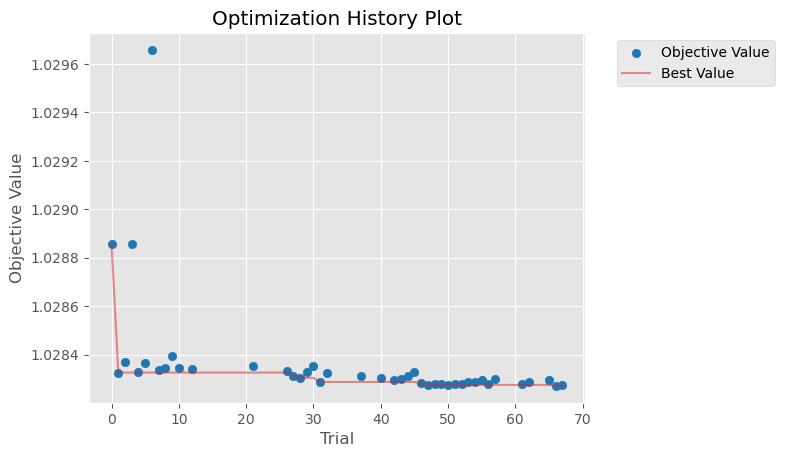

C:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:63: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(self.study)


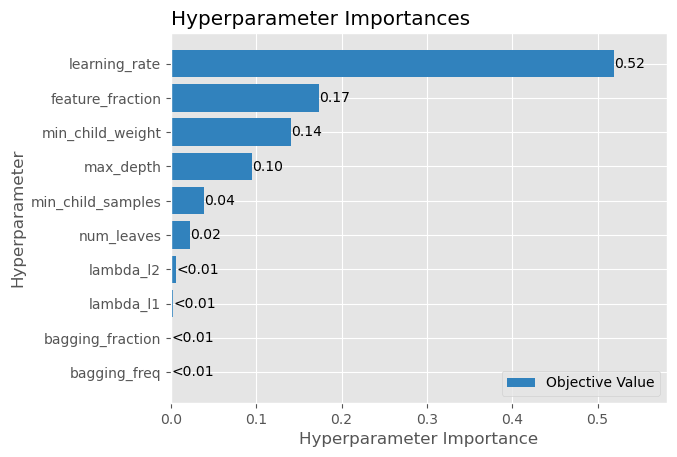

C:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:66: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(self.study)


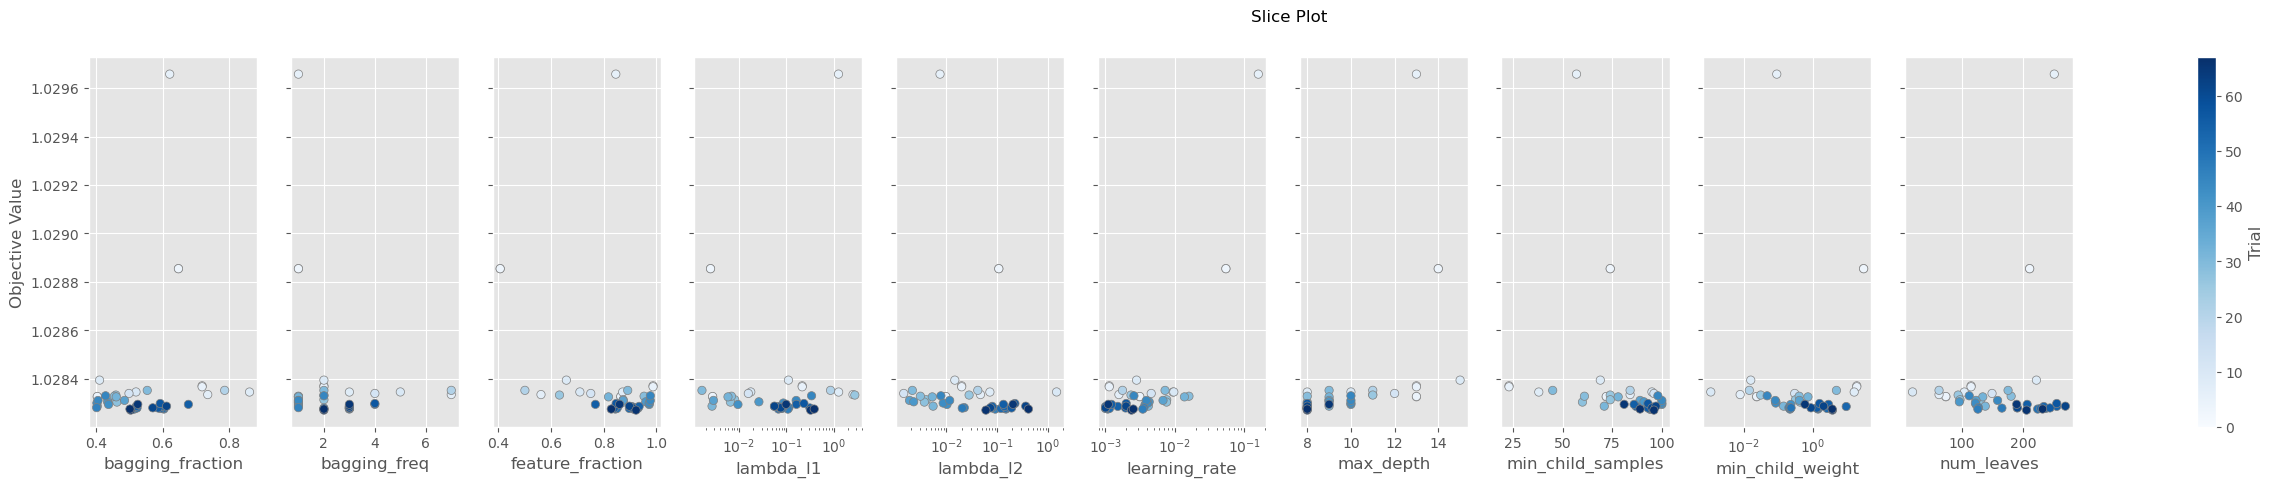

In [29]:
from axyom_utilities.hyperparameter_tuning import LGBMTuner

tuner = LGBMTuner(X_meta_train, y_train, 60*60*8, study_name="lgbm")
best_params = tuner.tune()
tuner.plot()

In [30]:
from axyom_utilities.wrappers import LGBMRegressorWrapper

results = train_model_cv(LGBMRegressorWrapper(**best_params), X_meta_train, y_train, X_meta_test, cv_splits=10)

Training fold 1...
Fold 1 RMSE: 1.0316
Training fold 2...
Fold 2 RMSE: 1.0264
Training fold 3...
Fold 3 RMSE: 1.0261
Training fold 4...
Fold 4 RMSE: 1.0306
Training fold 5...
Fold 5 RMSE: 1.0299
Training fold 6...
Fold 6 RMSE: 1.0248
Training fold 7...
Fold 7 RMSE: 1.0302
Training fold 8...
Fold 8 RMSE: 1.0289
Training fold 9...
Fold 9 RMSE: 1.0316
Training fold 10...
Fold 10 RMSE: 1.0256
Mean CV RMSE: 1.0286 ± 0.0025


In [31]:
results

{'oof_preds': array([6.88482412, 6.63293964, 6.76706411, ..., 5.29183316, 6.8478312 ,
        5.57737869]),
 'cv_scores': array([1.03163653, 1.0264052 , 1.02610188, 1.03055589, 1.02985294,
        1.02478066, 1.03017407, 1.0289283 , 1.03164607, 1.02564482]),
 'models': [LGBMRegressorWrapper(bagging_fraction=0.503867675545612, bagging_freq=2,
                       device='gpu', feature_fraction=0.922515788367696,
                       lambda_l1=0.32602039268982663,
                       lambda_l2=0.06007624643666558,
                       learning_rate=0.0023906510148033796, max_depth=8,
                       metric='rmse', min_child_samples=96,
                       min_child_weight=3.70799839068349, n_estimators=10000,
                       n_iterators=2066, num_leaves=205, objective='regression',
                       verbose=-1),
  LGBMRegressorWrapper(bagging_fraction=0.503867675545612, bagging_freq=2,
                       device='gpu', feature_fraction=0.922515788367696,

# Submission

In [33]:
# test_preds = results['LightGBM']['test_preds']
# score = results['LightGBM']['score']
# test_preds
# score = weight_ensembling_score

test_preds = results['test_preds']
score = np.mean(results['cv_scores'])

In [34]:
if False:
    y_pred = np.maximum(0, np.expm1(test_preds))

    submission = pd.DataFrame({
        'id': X_test.index,  
        'Premium Amount': y_pred
    })

    FILE_PATH = f"Stacking_v3_{score:.4f}.csv"

    submission.to_csv(FILE_PATH, index=False)